In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copy
from Bio import SeqIO
from scipy.stats import mannwhitneyu, median_abs_deviation, iqr

from utils.similarity import merge_samples

# Outils

- **notebook** : un type de fichier permettant d'intercaler des section de code et des section de texte, permet aussi d'afficher les plots directements (pratique pour décrire une analyse)
- **pyvcf** : librairie python pour parser des fichier vcf et récupérer les variants qui y sont référencé
- **Biopython** : librairie de bioinformatique qui nous permet ici de parser le fichier fasta contenant toutes les ORF du virus
- **pandas** : Permet de traiter des donnés tabulaires (type csv) efficacement et facilement (accession, filtrage, trie, ...) dans un objet appelé data_nf1Frame
- **seaborn** : Permet de réaliser des graphiques facilement à partir de DataFrame

# Récupération des données

Les variants structuraux de tous les échantillons pour tous les passage ont été récupérés au préalable sur le cluster et regroupés dans un fichier csv. Chaque variants est représenté par une donné avec les entrées suivantes:

- **id** : identifiant de la variation dans le fichier vcf
- **svtype** : type de variant (INS, DEL, INV, DUP)
- **pos** : position de début de la variation
- **end** : position de fin de la variation (pour une insertion pos = end)
- **svlen** : taille de la variation (négatif pour les délétions)
- **alt** : séquence du variant en cas d'insertion
- **dr, dv** : profondeur de read mappant sur la référence (dr) et mappant sur le variant (dv)
- **depth** : profondeur de read total sur cette région du génome (dr + dv)
- **af** : fréquence allélique ( dv / depth : proportion de read supportant cette inversion par rapport au reads mappés sur cette région)
- **sample** : échantillon d'origine (1 à 10)
- **iteration** : passage d'origine (15 à 90)
- **group** : les variants identiques sont regroupés avec un identifiant identique (voir ci dessous)

## Groupement des variants identiques

On veut pouvoir repérer les différentes occurences d'un même variant dans différentes expériences.
Pour cela les variants sont comparé entre eux en se basant sur les éléments suivants, qui doivent être identiques :
- La position de début
- La position de fin 
- La séquence alternative pour les insertions

Il a été choisis de grouper les variants seulement lorsqu'ils sont exactement identique pour être certain qu'ils ont le même impacte sur le fonctionnement biologique. Par ailleurs, cette méthode identifie de nombreuses occurences d'un même variant, ce qui montre que ce seuil est pertinent : pour 2 457 variants, 779 groupes ont été identifiés.

Il est possible de baisser le seuild de similarité pour grouper des variants proche même si ils ne sont pas identiques. Dans ce cas la les deux variants sont "alignés" position à position pour comparer le pourcentage de bases identiques, à la même position : par exemple si une insertion commence à la position 0 et une autre commence à la potition 5 on alignera comme ci dessous:

ATCGCCTGCT-------\
-----AGCCCAGATTAT

Nous avons remarqué que, a priori, baisser le seuil de similarité (même à 0.99) peut être particulièrement intéressant pour grouper les très grands variants. En effet l'insertion géante de l'ORF25 en particulier, est récurrente dans chaque échantillon mais sa position peut varier de quelques bases : elle n'est donc pas toujours identique, malgrès une très forte similarité.

**Remarque :** La valeur de similarié peut être adapté dans ce script en modifiant la variable sim_thresold ci dessous


In [2]:
sim_thresold = 0.75

data = pd.read_csv('../data/variants.csv', index_col="index").to_dict('records')
grouped = merge_samples(data, 1)
flat_grouped = []
for i, g in enumerate(grouped):
    for v in g:
        v["group"] = i
        flat_grouped.append(v)

data = pd.DataFrame(flat_grouped)

print(f"Avec un seuil de similarité à {sim_thresold} : {len(data["group"].unique())} groupes identifiés sur {len(data)} variants")

Avec un seuil de similarité à 0.75 : 780 groupes identifiés sur 2457 variants


In [3]:
# Catégorisation des colonnes 
data["iteration"] = pd.Categorical(data["iteration"])
data["sample"] = pd.Categorical(data["sample"])
data["group"] = pd.Categorical(data["group"])
data["svtype"] = pd.Categorical(data["svtype"])

# Précalcul de dcertaines donnés pour un accès plus simple
data["choc"] = pd.Categorical(data.apply(lambda x: "cold" if x["sample"] <= 5 else "heat", axis=1))
data["period"] = pd.Categorical(data.apply(lambda x: "before" if x["iteration"] == 15 else ("choc" if x["iteration"] == 30 else "after"), axis=1))

samples = data["sample"].astype(int).unique()
samples.sort()
iterations = data["iteration"].astype(int).unique()
iterations.sort()
chocs = ["cold", "heat"]
periods = ["before", "choc", "after"]

# Copy du jeu de données avants les filtres
data_init = pd.DataFrame(
    columns = data.columns, data = copy.deepcopy(data.values)
)
data_init["iteration"] = pd.Categorical(data["iteration"])
data_init["sample"] = pd.Categorical(data["sample"])
data_init["group"] = pd.Categorical(data["group"])
data_init["svtype"] = pd.Categorical(data["svtype"])

data.head()

,pos,id,svtype,svlen,end,af,dv,dr,depth,alt,ref,sample,iteration,group,choc,period
0,1,Sniffles2.DUP.705S0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,1,15,0,cold,before
1,1,Sniffles2.DUP.3B3S0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,1,30,0,cold,choc
2,1,Sniffles2.DUP.29FS0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,1,50,0,cold,after
3,1,Sniffles2.DUP.6ADS0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,2,15,0,cold,before
4,1,Sniffles2.DUP.1AS0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,2,30,0,cold,choc


# Filtrage des données

## Fréquence allélique et profondeur

Pour déterminer des filtres de fréquences alléliques et de profondeur minimum qui soit pertinent on regarde quelles sont les valeurs observés dans les différents passage. Il est nécessaire de regarder tous les passages indépendament puisque la qualité globale du séquencage diffère d'un passage à l'autre. On choisiras cependant un seuil fixe pour l'ensemble des passage afin de rester consistant.

Pour les fréquences allélique, on voit sur l'histogramme on remarque une démarquation à 0.05 (ligne rouge): comme une grande quantité d'observations se situe en dessous de ce seuil, il est pertinent de considérer que ces observations sont les moins significatives.

Ce raisonnement est plus compliqué à appliquer sur les profondeur qui ne sont pas aussi distinctement répartis, on peut afficher des violin plots pour voir la distribution de chaque passage. La largeur du graphique représente la proportion de reads à une valeur donnée de profondeur, un boxplot est représenté à l'interieur en noir. On voit qu'avec un filtre à 1100 on écarte moins de 25% des variants, cette valeur semble pertinente.

Le dernier graphique représente chaque variant par un point positioné en fonction de sa profondeur (absysses) sa fréquence allélique (ordonnées).

Enfin avec des seuils à 0.05 et 1100 on conservera des variants supportés par 55 reads minimum ce qui est significatif (0.05 * 1100).

**Remarque :** ce sont les groupes de variants (cf description plus haut) identiques qui sont filtrés et non les variants individuellement, par exemple si un variant est présent à P15 et ne remplis pas les conditions pour passer le filtre, mais qu'il est aussi présent à P50, cette fois en fréquence et en profondeur suffisante, les deux occurences seront conservé. En effet cela nous donne un information plus pertinentes sur les variants et nous permets de considérer les différents passages ensembles. On affiche donc les fréquences maximale pour chaque groupe de variants identiques.

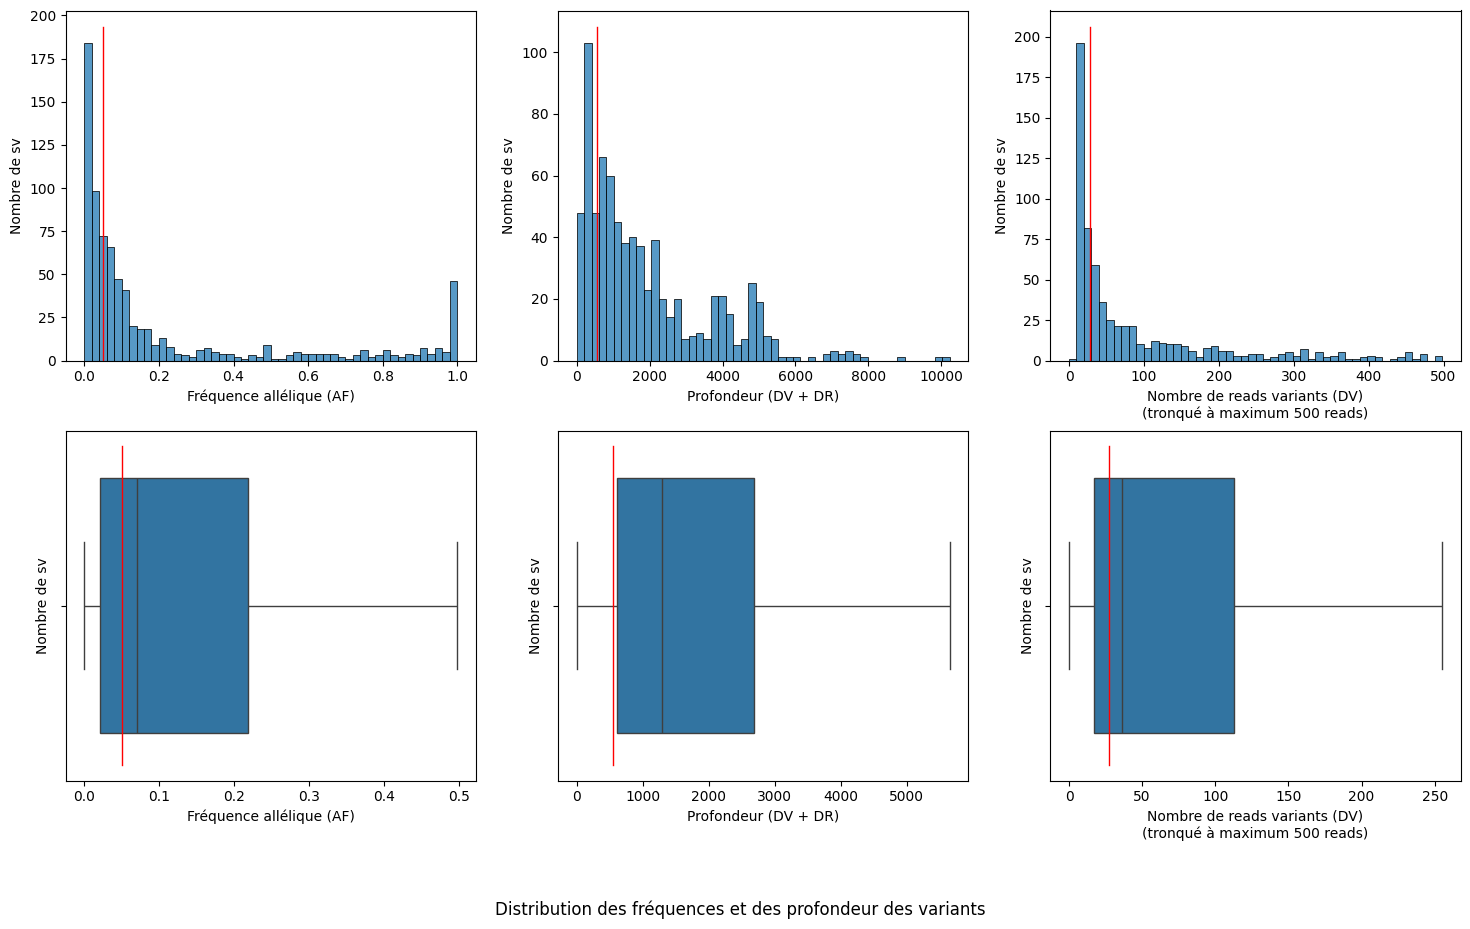

In [4]:
fig, (r1, r2) = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
ax1, ax2, ax3 = r1
ax4, ax5, ax6 = r2

data_max_dv = data_init.sort_values('dv', ascending=False).drop_duplicates(['group'])

freq_lim = 0.05
depth_lim = 550
dv_lim = freq_lim * depth_lim

# Fréquence
sns.histplot(data=data_max_dv, x="af", bins=50, ax=ax1)
ax1.set_xlabel("Fréquence allélique (AF)")
ax1.set_ylabel("Nombre de sv")

sns.boxplot(data=data_max_dv, x="af", ax=ax4, showfliers=False)
ax4.set_xlabel("Fréquence allélique (AF)")
ax4.set_ylabel("Nombre de sv")

ax1.plot([freq_lim, freq_lim], [ax1.get_ylim()[0], ax1.get_ylim()[1]], 'r-', lw=1)
ax4.plot([freq_lim, freq_lim], [ax4.get_ylim()[0], ax4.get_ylim()[1]], 'r-', lw=1)

# Depth
sns.histplot(data=data_max_dv, x="depth", bins=50, ax=ax2)
ax2.set_xlabel("Profondeur (DV + DR)")
ax2.set_ylabel("Nombre de sv")

sns.boxplot(data=data_max_dv, x="depth", ax=ax5, showfliers=False)
ax5.set_xlabel("Profondeur (DV + DR)")
ax5.set_ylabel("Nombre de sv")

ax2.plot([depth_lim, depth_lim], [ax2.get_ylim()[0], ax2.get_ylim()[1]], 'r-', lw=1)
ax5.plot([depth_lim, depth_lim], [ax5.get_ylim()[0], ax5.get_ylim()[1]], 'r-', lw=1)

# DV
sns.histplot(data=data_max_dv[data_max_dv["dv"] <= 500], x="dv", bins=50, ax=ax3)
ax3.set_xlabel("Nombre de reads variants (DV)\n(tronqué à maximum 500 reads)")
ax3.set_ylabel("Nombre de sv")

sns.boxplot(data=data_max_dv[data_max_dv["dv"] <= 500], x="dv", ax=ax6, showfliers=False)
ax6.set_xlabel("Nombre de reads variants (DV)\n(tronqué à maximum 500 reads)")
ax6.set_ylabel("Nombre de sv")

ax3.plot([dv_lim, dv_lim], [ax3.get_ylim()[0], ax3.get_ylim()[1]], 'r-', lw=1)
ax6.plot([dv_lim, dv_lim], [ax6.get_ylim()[0], ax6.get_ylim()[1]], 'r-', lw=1)


#sns.scatterplot(data=data_max_dv[(data_max_dv["iteration"].isin([90, 15, 65, 30, 50])) & (data_max_dv["depth"] > 50)], x="max_depth", y="max_af", ax=ax3)
#ax3.plot([ax3.get_xlim()[0], ax3.get_xlim()[1]], [0.05, 0.05], 'r-', lw=1)
#ax3.plot([1100.0, 1100.0], [ax3.get_ylim()[0], ax3.get_ylim()[1]], 'r-', lw=1)
#ax3.set_xlabel("Profondeur de l'alignement maximale")
#ax3.set_ylabel("Fréquence allélique maximale")
#ax3.set_yscale("log")
#ax3.set_xscale("log")

plt.suptitle("Distribution des fréquences et des profondeur des variants", y=-0.01)
#plt.show()
plt.savefig("../results/figs/choose_filter.pdf")

**Remarque :** On peut ci dessous choisir les filtres filter_af et filter_depth pour changer les seuils

In [5]:
filter_af = 0
filter_depth = 0
filter_dv = int(filter_af * filter_depth)

passed = data_max_dv[(data_max_dv["af"] >= filter_af) & (data_max_dv["depth"] >= filter_depth)]["group"].values
data = data[data["group"].isin(passed)]

## Repérer les outliers

Des outliers sont des données inattendu qui peuvent possiblement être causé par des bugs. Dans notre cas on sait que les régions au début et à la fin du génome sont répétés, ce qui peut conduire à détecter de larges insertions dans ces régions.
Afficher la distribution des longueurs de variants dans un box plot nous permet de les repérer pour les filtrer correctement. 

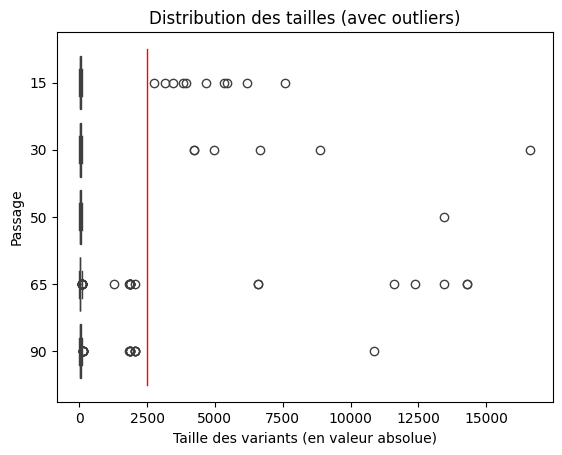

In [6]:
fig, ax = plt.subplots()
data_filt = data_init.groupby(["group"], observed=True).filter(lambda x: x["af"].max() > filter_af and x["depth"].max() > filter_depth)
sns.boxplot(data=data_filt[(30000 < data_filt["pos"]) & (data_filt["pos"] < 270000)], x=abs(data_filt[(30000 < data_filt["pos"]) & (data_filt["pos"] < 270000)]["svlen"]), y="iteration", showfliers=True, ax=ax)
ax.set_xlabel("Taille des variants (en valeur absolue)")
ax.set_ylabel("Passage")
ax.set_title("Distribution des tailles (avec outliers)")

plt.plot([2500.0, 2500.0], [ax.get_ylim()[0], ax.get_ylim()[1]], 'r-', lw=1)
plt.show()

En observant plus en détails ces donnés on remarque que soit ces variants sont positionnés au bornes du génomes, soit ce sont des régions répétés.
Ci dessous tous les variants d'une taille superieur à 2 500 entre les positions 20 000 et 280 000.

On décidera donc de filtrer les variants qui ont une taille supérieur à 2 500.

In [7]:
def truncate(x):
    if x["svtype"] == "INS":
        x["alt"] = x["alt"][max(len(x["alt"]) - 20, 0):] 
    return x

outliers = data.copy(deep=True)
outliers["svlen"] = abs(outliers["svlen"])
outliers = outliers[(outliers["svlen"] > 2500) & (outliers["pos"] > 20000) & (outliers["pos"] < 280000)]
outliers = outliers.sort_values("pos").sort_values("svlen", ascending=False)

outliers = outliers.apply(truncate, 1)
outliers[["svlen", "pos", "alt"]]

,svlen,pos,alt
2453,23059,272448,<INS>
1774,16622,196282,AAAAAAAAAAAAAAAAAAAA
2013,14282,229191,N
2014,14282,229191,N
2019,13429,229512,N
2018,13429,229512,N
2016,12376,229478,N
2017,11599,229506,N
2015,10870,229409,N
2452,10394,272446,<INS>


**Remarque :** La variable max_len ci dessous permet de choisir la taille maximal des variants conservés.

In [8]:
max_len = 2500
data = data[abs(data["svlen"]) < max_len]

## Impacte du filtrage

On superpose les données aux différentes étapes du filtrage pour comprendre l'impacte et voir la quantité de données conservés. Contrairement au graphique qu'on à fait au début on considère ici chaque variant indépendament, cela permet de rendre compte de la quantité de variants qui ont été filtrés.

Proportion de variants conservés : 0.9715099715099715


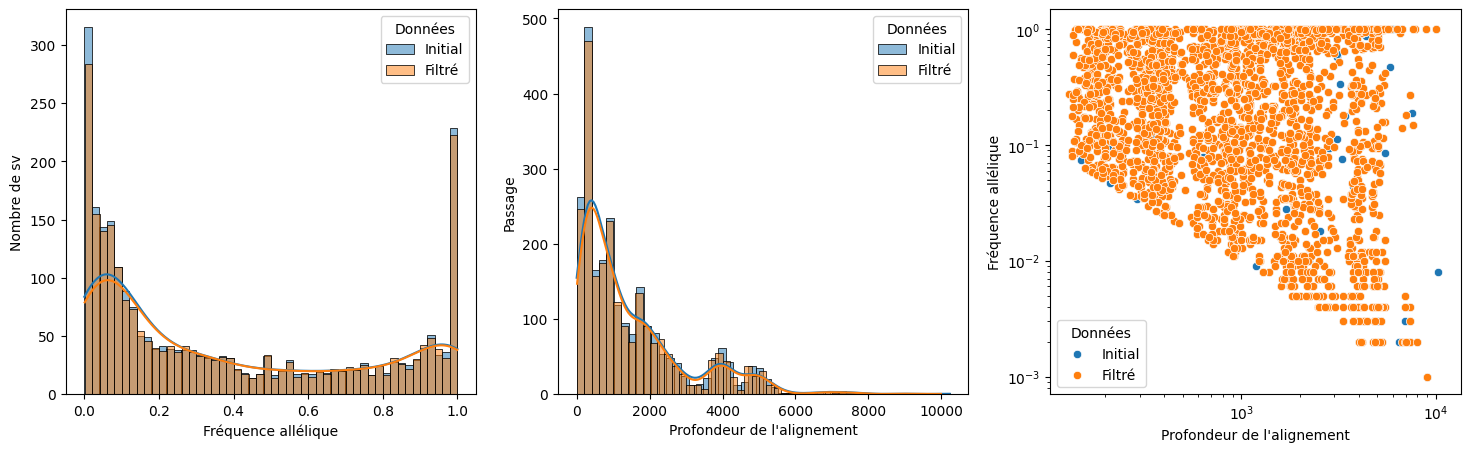

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.histplot(data=data_init, x="af", label="Initial", kde=True, bins=50, ax=ax1)
sns.histplot(data=data, x="af", label="Filtré", kde=True, bins=50, ax=ax1)
ax1.set_xlabel("Fréquence allélique")
ax1.set_ylabel("Nombre de sv")
ax1.legend(title="Données")

sns.histplot(data=data_init, x="depth", label="Initial", kde=True, bins=50, ax=ax2)
sns.histplot(data=data, x="depth", label="Filtré", kde=True, bins=50, ax=ax2)
ax2.legend(title="Données")

sns.scatterplot(data=data_init[(data_init["depth"] > 50)], x="depth", y="af", label="Initial", ax=ax3)
sns.scatterplot(data=data[(data["depth"] > 50)], x="depth", y="af", label="Filtré", ax=ax3)
ax2.set_xlabel("Profondeur de l'alignement")
ax2.set_ylabel("Passage")
ax3.legend(title="Données")


ax3.plot([ax3.get_xlim()[0], ax3.get_xlim()[1]], [filter_af, filter_af], 'r-', lw=1)
ax3.plot([filter_depth, filter_depth], [ax3.get_ylim()[0], ax3.get_ylim()[1]], 'r-', lw=1)
ax3.set_xlabel("Profondeur de l'alignement")
ax3.set_ylabel("Fréquence allélique")
ax3.set_yscale("log")
ax3.set_xscale("log")

print("Proportion de variants conservés :", len(data)/len(data_init))
#plt.show()
plt.savefig("res_filter.pdf")

## Extraire les variants qui interfèrent avec un ORF connu

Pour cela on extrait tous les ORFs connues du virues à partir d'un fichier FASTA. Si une variation structurelle chevauche un ou plusieurs ORFs, on noteras lesquel.

In [10]:
orfs = []
margin = 100 # distance maximal de la mutation à l'orf

for seq in SeqIO.parse("../data/ORF.fasta", "fasta"):
    header = seq.description

    locus_tag = header.split("[")[1][:-2].split("=")[1]
    protein_id = header.split("[")[4][:-2].split("=")[1]

    locations = header.split("[")[5][:-2].split("(")[-1].split("=")[-1].split(")")[0].split(",")
    locations = [inter.split("..") for inter in locations]

    complement = 'complement' in header.split("[")[5]
    join = 'join' in header.split("[")[5]

    start_orf = min(locations, key=lambda x: x[0])[0]
    end_orf = min(locations, key=lambda x: x[1])[1]

    orfs += [{'locus_tag': locus_tag, 'protein_id': protein_id, 'location': loc, 'complement': complement, 'join': join} for loc in locations]


def intersected_orfs(pos, end, type):
    result = []
    for o in orfs:
        if type == "INS" and pos - int(o["location"][0]) + margin > 0 and pos - int(o["location"][1]) - margin < 0:
            result.append(o["locus_tag"])
        elif type != "INS" and min(end, int(o["location"][1])) - max(pos, int(o["location"][0])) + margin > 0:
            result.append(o["locus_tag"])
    return result

families = {
    "ORF2": [2, 9],
    "TNFR": [4, 12],
    "ORF22": [22, 24, 137],
    "ORF25": [25, 26, 27, 65, 148, 149],
    "RING": [41, 128, 144, 150],
    "conserved": [19, 33, 46, 47, 48, 61, 71, 72, 78, 79, 80, 90, 92, 99, 107, 123]
}

def get_families(var_orfs):
    f = []
    for orf in var_orfs:
        for k, v in families.items():
            for i in v:
                if orf == f"CyHV3_ORF{i}" or orf.startswith(f"CyHV3_ORF{i}_"):
                    f.append(k)
    return list(set(f))
            

In [11]:
data["orfs"] = data.apply(lambda x: intersected_orfs(x["pos"], x["end"], x["svtype"]), axis=1)
data["families"] = data.apply(lambda x: get_families(x["orfs"]), axis=1)
data_orfs = data[data["orfs"].astype(bool)]
data_orfs.shape

(2122, 18)

## Extraire les variants qui sont dans des régions non répétés

In [12]:
repeated = []

with open("../data/Red/NC_009127.rpt", 'r') as f:
    for line in f:
        rpt = line.split(":")[1].split("-")
        rpt = [int(r) for r in rpt]
        repeated.append(rpt)

def in_rep(pos, svlen, thresold=1):
    end = pos + abs(svlen)
    rep_len = 0
    for r in repeated:
        shared_len = min(end, r[1]) - max(pos, r[0])
        rep_len += max(0, shared_len)
    return rep_len / abs(svlen) >= thresold

In [13]:
not_in_rep = data_orfs.apply(lambda x: not in_rep(x["pos"], x["svlen"]), axis=1)
data_orfs = data_orfs[not_in_rep]
data_orfs.shape

(717, 18)

## Distance matrices

In [69]:
from scipy.spatial.distance import cosine
import math

N = 100


def dtw_distance(time_series_A, time_series_B):
    n = len(time_series_A)
    m = len(time_series_B)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(1, n+1):
        for j in range(1, m+1):
            # Computing the cost by using the above mathematical formula &
            # Finding the absolute difference between two values
            cost = abs(time_series_A[i-1] - time_series_B[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],
                                        dtw_matrix[i, j-1],
                                        dtw_matrix[i-1, j-1])
    return dtw_matrix[n, m]

def internal_cohesion(matrix, metric):
    total = 0
    for i in range(matrix.shape[0]):
        for j in range(0, i):
            if metric == 'dtw':
                total += dtw_distance(matrix[i], matrix[j])
            elif metric == 'cos':
                if sum(matrix[i]) == 0 or sum(matrix[j]) == 0:
                    if sum(matrix[i]) > 0:
                        total += (np.linalg.norm(matrix[i]) / np.linalg.norm([100] * len(matrix[i]))) * 2
                    elif sum(matrix[j]) > 0:
                        total += (np.linalg.norm(matrix[j]) / np.linalg.norm([100] * len(matrix[j]))) * 2
                else:
                    total += cosine(matrix[i], matrix[j])
            elif metric == 'eucl':
                total += math.dist(matrix[i], matrix[j])
            else:
                raise Exception("invalid dist")
    return total / ((matrix.shape[0] * (matrix.shape[0] - 1)) / 2)

def external_separation(matrix, metric):
    total = 0
    for i in range(0, 5):
        for j in range(5, 10):
            if metric == 'dtw':
                total += dtw_distance(matrix[i], matrix[j])
            elif metric == 'cos':
                if sum(matrix[i]) == 0 or sum(matrix[j]) == 0:
                    if sum(matrix[i]) > 0:
                        total += (np.linalg.norm(matrix[i]) / np.linalg.norm([100] * len(matrix[i]))) * 2
                    elif sum(matrix[j]) > 0:
                        total += (np.linalg.norm(matrix[j]) / np.linalg.norm([100] * len(matrix[j]))) * 2
                else:
                    total += cosine(matrix[i], matrix[j])
            elif metric == 'eucl':
                total += math.dist(matrix[i], matrix[j])
            else:
                raise Exception("invalid dist")
    return total / 25

def plot_variant(v, ax):
    freqs = v["freqs"]
    cold_colors = plt.cm.Blues(np.linspace(0.4, 0.8, 5))
    warm_colors = plt.cm.Reds(np.linspace(0.4, 0.8, 5))
    
    for i in range(10):
        if i < 5:
            sns.lineplot(data=freqs[i], label=f'{i+1}', color=cold_colors[i], ax=ax)
        else:
            sns.lineplot(data=freqs[i], label=f'{i+1}', color=warm_colors[i-5], ax=ax)
    

    ax.set_title(f"Variant {v["group"]} in ORFs {v["orfs"]}\ncohes={v["cohes_mean"]} and sep={v["sep"]}")
    ax.set_xlabel("Passages (P15 à P90)")
    ax.set_xticks(list(range(5)), labels=["P15", "P30", "P50", "P65", "P90"])
    ax.set_ylabel("Fréquence allélique (en %)")
    ax.legend(title="Sample")

In [15]:
N = 100
results = []
metric = 'cos'

data_orfs_grouped = data_orfs.groupby(["group"])

for g in data_orfs["group"].unique():
    group = data_orfs_grouped.get_group(g)
    freqs = np.zeros(shape=(10, 5))
    for _, x in group.iterrows():
        index = 0
        if x["iteration"] == 30:
            index = 1
        if x["iteration"] == 50:
            index = 2
        elif x["iteration"] == 65:
            index = 3
        if x["iteration"] == 90:
            index = 4
        
        freqs[x["sample"] - 1, index] = x["af"] * N
    

    n_cold = len([x for x in freqs[:5] if sum(x) > 0])
    n_heat = len([x for x in freqs[5:] if sum(x) > 0])
    if n_cold + n_heat < 4:
        continue
    
    cohes_c, cohes_h = internal_cohesion(freqs[:5], metric), internal_cohesion(freqs[5:], metric)
    cohes_mean = (cohes_c + cohes_h) / 2
    sep = external_separation(freqs, metric)

    n_cold = len([x for x in freqs[:5] if sum(x) > 0])
    n_heat = len([x for x in freqs[5:] if sum(x) > 0])

    results.append({
        "group": g, "id": group["id"].values[0], "type": group["svtype"].values[0],
        "n_cold": n_cold, "n_heat": n_heat, 
        "cohes_c": round(cohes_c, 2), "cohes_h": round(cohes_h, 2), 
        "cohes_mean": round(cohes_mean, 2), "cohes_min": round(min(cohes_h, cohes_c), 2), 
        "sep": round(sep, 2),
        "score": round(sep / cohes_mean, 2),
        "orfs": group.iloc[0]["orfs"], "families": group.iloc[0]["families"],
        "freqs": freqs
    })

data_dist = pd.DataFrame(results)

In [16]:
sorting = "cohes_mean"
data_dist = data_dist.sort_values([sorting], ascending=sorting.startswith("cohes"))

cols = ["group", "n_cold", "n_heat", "cohes_min", "cohes_mean", "sep", "score", "orfs", "families", "id"]
data_dist[cols]

,group,n_cold,n_heat,cohes_min,cohes_mean,sep,score,orfs,families,id
27,643,3,3,0.00,0.00,0.00,0.80,[CyHV3_ORF133],[],Sniffles2.INS.2B7S0
24,597,3,1,0.00,0.02,0.04,1.49,[CyHV3_ORF122],[],Sniffles2.DEL.5FFS0
31,729,5,5,0.10,0.12,0.20,1.63,[CyHV3_ORF154],[],Sniffles2.INS.3DBS0
29,672,5,5,0.09,0.14,0.16,1.15,[CyHV3_ORF135],[],Sniffles2.INS.352S0
7,227,1,3,0.03,0.16,0.12,0.75,[CyHV3_ORF19],[conserved],Sniffles2.INS.33S0
13,289,3,2,0.11,0.16,0.21,1.32,[CyHV3_ORF30],[],Sniffles2.INS.C7S0
15,291,5,5,0.08,0.17,0.20,1.16,[CyHV3_ORF30],[],Sniffles2.INS.5BS0
2,146,1,4,0.02,0.17,0.15,0.89,[CyHV3_ORF17],[],Sniffles2.DEL.100S0
9,272,5,5,0.18,0.19,0.16,0.84,[CyHV3_ORF25],[ORF25],Sniffles2.INS.AES0
30,679,5,5,0.16,0.20,0.21,1.09,[CyHV3_ORF136],[],Sniffles2.INS.35AS0


In [72]:
selected = [31, 29, 9, 32, 26, 12, 21, 30, 15, 0, 23, 17, 20]
data_manual = data_dist.loc[selected]
data_alike = data_dist.loc[[17, 20]]
groups_manual = data_manual["group"].values
candidates = data_orfs[data_orfs["group"].isin(groups_manual)].sort_values("af", ascending=True).drop_duplicates("group")
groups_alike = data_alike["group"].values
alike = data_orfs[data_orfs["group"].isin(groups_alike)].sort_values("af", ascending=True).drop_duplicates("group")

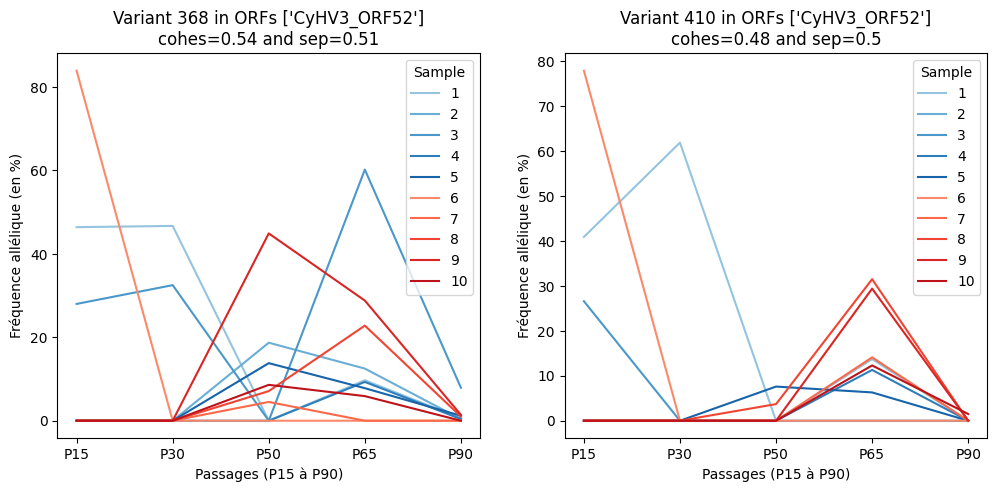

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(hspace=0.5)

i = 0
for _, row in data_alike.iterrows():
    plot_variant(row, axes[i])
    i+=1

plt.savefig("../results/similars.pdf")

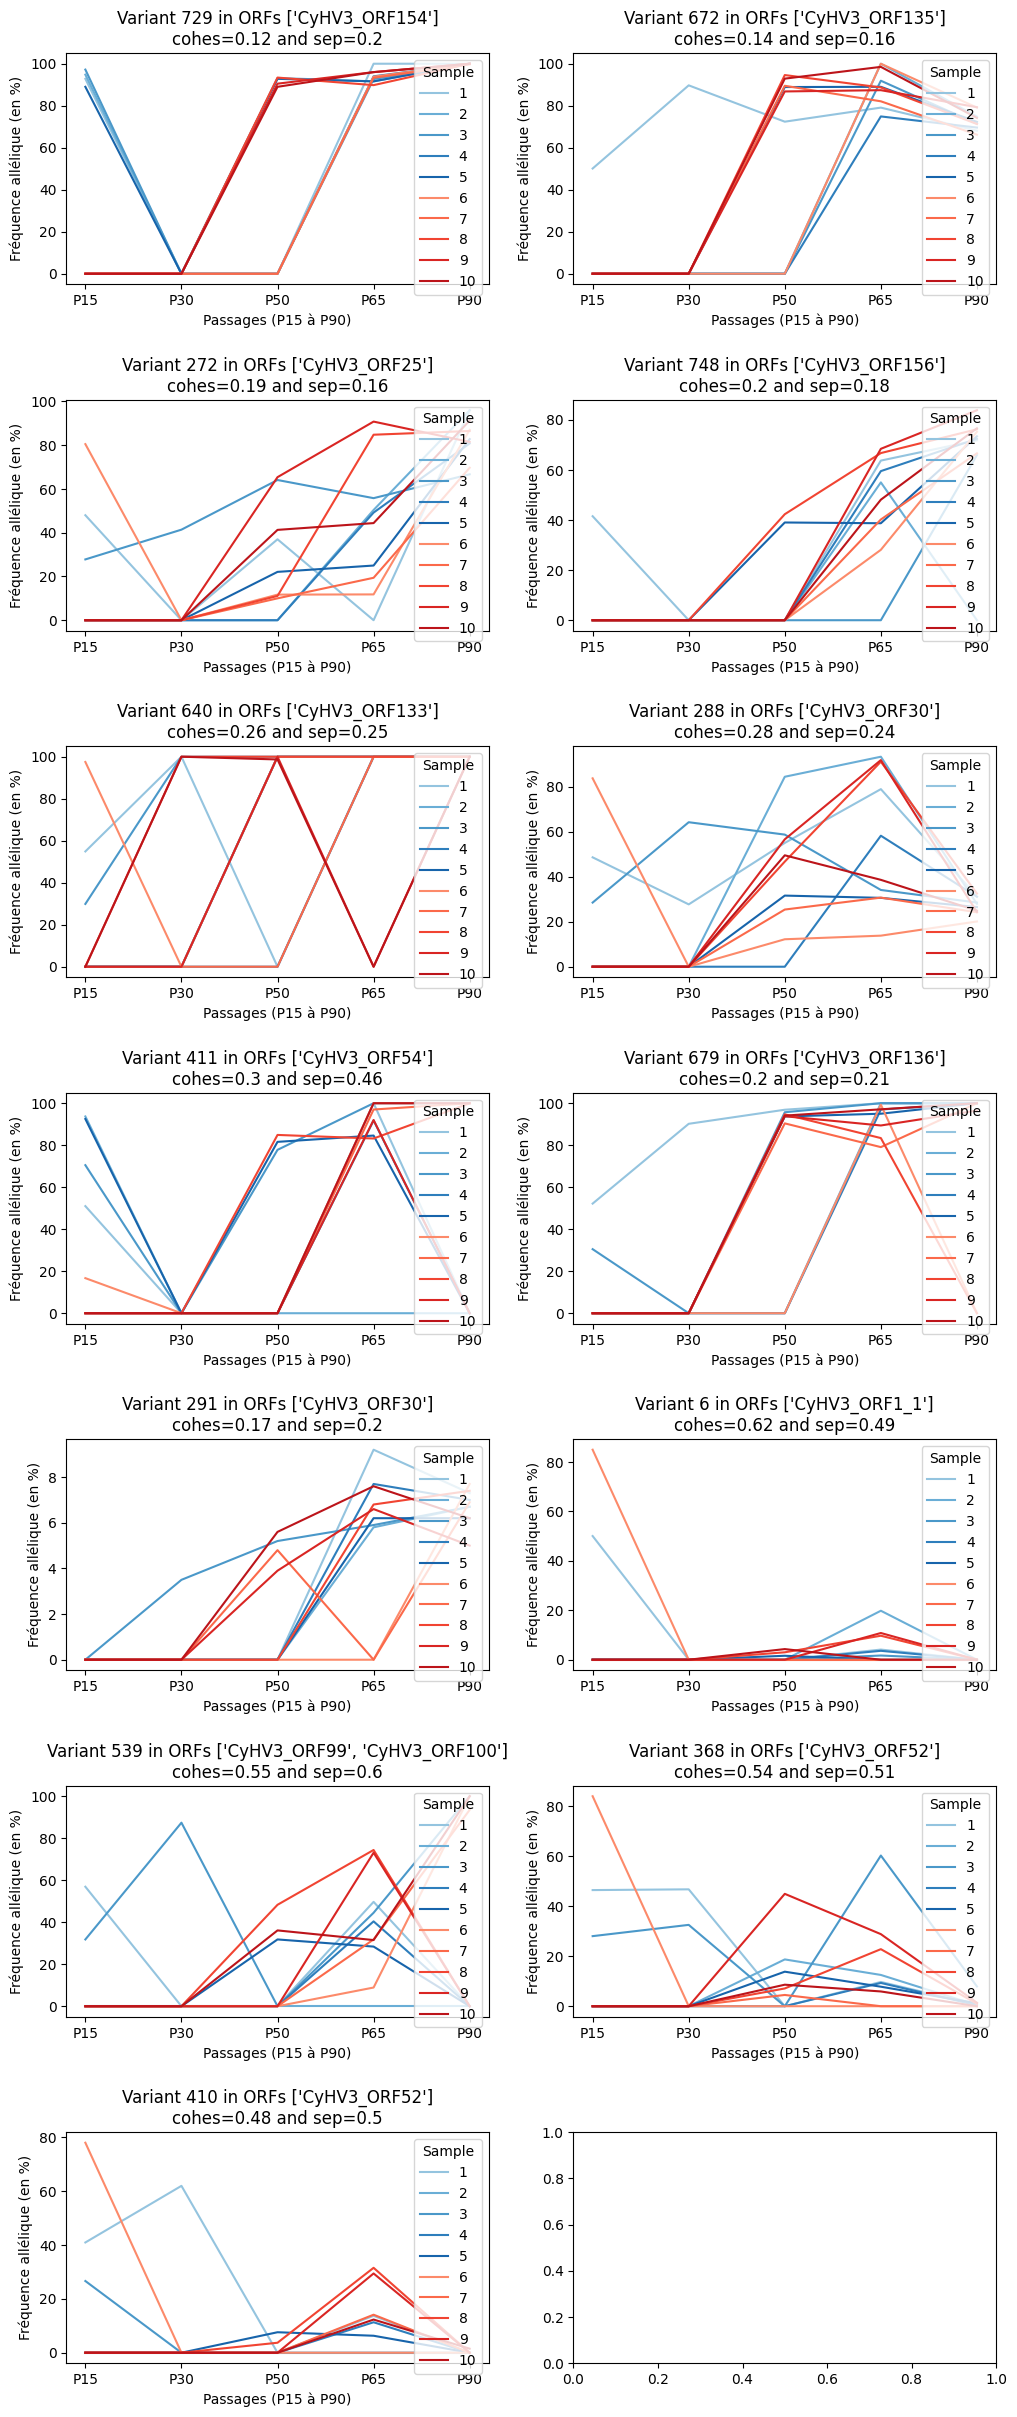

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 35))
plt.subplots_adjust(hspace=0.5)

i = 0
j = 0
for _, row in data_manual.iterrows():
    plot_variant(row, axes[j, i])
    i+=1
    if i > 1:
        i = 0
        j += 1

plt.savefig("../results/candidates.pdf")